In [1]:
from copy import deepcopy
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sac import SAC
from citylearn.agents.sac import  SACBasicBatteryRBC as Agent
from citylearn.citylearn import CityLearnEnv
from citylearn.cost_function import CostFunction
from citylearn.utilities import read_json

In [2]:
TIMESTAMPS = pd.DataFrame(pd.date_range('2016-08-01 00:00:00','2017-07-31 23:00:00',freq='H'),columns=['timestamp'])
TIMESTAMPS['time_step'] = TIMESTAMPS.index

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

root_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/citylearn_challenge_2022_phase_1/')
schema = os.path.join(root_directory, 'schema.json')
schema = read_json(schema)
schema['root_directory'] = root_directory

# use only 1 building
schema['buildings'] = {'Building_1': schema['buildings']['Building_1']}
schema['reward_function']['type'] = 'reward.RampingReward'
active_observations = ['hour','direct_solar_irradiance_predicted_6h','non_shiftable_load','solar_generation','electrical_storage_soc']

for o in schema['observations']:
    schema['observations'][o]['active'] = True if o in active_observations else False

env = CityLearnEnv(schema)
env.central_agent = False

# define agent attributes (these hyperparameters are arbitrary and should be tuned to maximize performance).
agent_kwargs = {
    'building_ids': [b.uid for b in env.buildings],
    'buildings_states_actions': {b.uid:{'states':{o:True for o in b.active_observations}} for i, b in enumerate(env.buildings)},
    'building_info': env.get_building_information(),
    'observation_spaces': env.observation_space,
    'action_spaces':env.action_space,
    "hidden_dim": [
    256,
    256
    ],
    "discount": 0.99,
    "tau": 5e-3,
    "lr": 3e-4,
    "batch_size": 256,
    "replay_buffer_capacity": 100000.0,
    "start_training": 1000,
    "exploration_period": 3000,
    "action_scaling_coef": 0.5,
    "reward_scaling": 5.0,
    "update_per_step": 2,
    "seed": 0,
}


In [14]:
# construct agents. Since central_agent property = False, the env.action_space will have a length = number of buildings.
# define number of episodes
episodes = 5
agent = SAC(**agent_kwargs)
# begin simulation for each episde
for episode in range(episodes):
    action_history = []
    # for each episode, first reset environment and get initial observations
    observations = env.reset()

    while not env.done:
        # select actions
        actions, _ = agent.select_action(observations)
        action_history.append(actions[0].tolist())

        # apply actions to citylearn_env
        next_observations, reward_list, _, _ = env.step(actions)

        # update policy
        agent.add_to_buffer(observations, actions, reward_list, next_observations, env.done, None, None)

        observations = [o for o in next_observations]

        # print progress
        print(
            f'\rTime step: {env.time_step}/{env.time_steps - 1},'\
                f' Episode: {episode}/{episodes - 1},'\
                    f' Actions: {actions}',
            end=' '*10
        )

    b = env.buildings[0]
    rewards = pd.DataFrame(env.rewards)
    actions = pd.DataFrame(action_history+[[0.0]])
    data = pd.DataFrame({
        'net_electricity_consumption':b.net_electricity_consumption,
        'net_electricity_consumption_emission':b.net_electricity_consumption_emission,
        'net_electricity_consumption_price':b.net_electricity_consumption_price,
        'net_electricity_consumption_without_storage':b.net_electricity_consumption_without_storage,
        'net_electricity_consumption_emission_without_storage':b.net_electricity_consumption_without_storage_emission,
        'net_electricity_consumption_price_without_storage':b.net_electricity_consumption_without_storage_price,
        'net_electricity_consumption_without_storage_and_pv':b.net_electricity_consumption_without_storage_and_pv,
        'electrical_storage_soc':b.electrical_storage.soc,
        'electrical_storage_electricity_consumption':b.electrical_storage.electricity_consumption,
        'action':(actions[0].iloc[-8760:]*b.electrical_storage.capacity).tolist(),
        'reward':rewards[0],
    })
    data['time_step'] = data.index
    data['episode'] = episode
    data = data.merge(TIMESTAMPS, on='time_step', how='left')
    data['month'] = data['timestamp'].dt.month
    data['year'] = data['timestamp'].dt.year
    data.to_csv(f'/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/single_building/orig_episode_{episode}.csv',index=False)

Time step: 8759/8759, Episode: 4/4, Actions: [[-0.05657912]]             

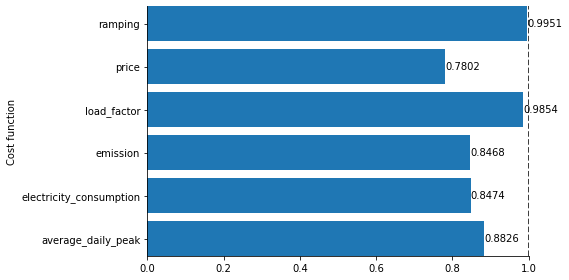

In [15]:
suffixes = ['', '_without_storage']
group_list = []

for suffix in suffixes:
    for episode, group in data.groupby(['episode']):
        group = group.copy()
        column = 'net_electricity_consumption' + suffix
        group['average_daily_peak'] = CostFunction.average_daily_peak(group[column])
        group['load_factor'] = CostFunction.load_factor(group[column])
        group['ramping'] = CostFunction.ramping(group[column])
        group['emission'] = CostFunction.carbon_emissions(group['net_electricity_consumption_emission'+suffix])
        group['price'] = CostFunction.price(group['net_electricity_consumption_price'+suffix])
        group['electricity_consumption'] = CostFunction.net_electricity_consumption(group[column])
        group['storage'] = 'without_storage' if 'without' in suffix else 'with_storage'
        group_list.append(group)

plot_data = pd.concat(group_list,ignore_index=True)
del group_list
plot_data = plot_data.melt(
    id_vars=['episode','time_step','storage'],
    value_vars=['average_daily_peak','load_factor','ramping','emission','price','electricity_consumption'],
    var_name='cost_function'
)
plot_data = plot_data.pivot_table(index=['episode','time_step','cost_function'],columns='storage',values='value')
plot_data = plot_data.reset_index()
plot_data['score'] = plot_data['with_storage']/plot_data['without_storage']

# final score
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count,column_count,figsize=(column_count*8,row_count*4),sharex=True,sharey=True)
final_data = plot_data[
    (plot_data['episode']==plot_data['episode'].max())
    &(plot_data['time_step']==plot_data['time_step'].max())
].copy()
y = final_data['score']
x = final_data['cost_function']
rects = ax.barh(x,y)
ax.bar_label(rects,fmt='%.4f',label_type='edge')
ax.axvline(1.0,color='black',linestyle='--')
ax.set_ylabel('Cost function')
ax.set_yticks(x.tolist())
ax.set_yticklabels(x.tolist())
ax.spines[['right','top']].set_visible(False)
plt.tight_layout()
plt.show()